In [10]:
import os
import shutil
import PIL
import numpy as np
import cv2
import zipfile
from PIL import Image
import tensorflow as tf
import pandas as pd
import pathlib
import gradio_cgan as gr

import matplotlib.pyplot as plt
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%load_ext autotime

print(tf.__version__)
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

ModuleNotFoundError: No module named 'PIL'

In [4]:
def dice_score(y_true, y_pred, threshold=0.5):
    smooth = 1.
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred >= threshold, [-1]), dtype=tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1. - dice_score(y_true, y_pred)
    return tf.cast(loss, dtype=tf.float32)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

time: 723 µs (started: 2024-04-27 19:56:40 +00:00)


In [5]:
model_path = "/notebooks/saved_model/final/final_4block_RMSprop_swish+leakyrelu_CGAN_900_clahe_generator.h5"
model = tf.keras.models.load_model(model_path,  
                                        custom_objects={'bce_dice_loss':bce_dice_loss,
                                                        'dice_score': dice_score})

2024-04-27 19:56:40.697414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 19:56:40.704257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 19:56:40.704441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

time: 2.29 s (started: 2024-04-27 19:56:40 +00:00)


In [6]:
def readImages(data, typeData):
    images = []
    height = int(256)
    width = int(512)
    for img in data:
        img = cv2.imread(str(img), 0)
        img = cv2.resize(img, (width, height))
        if typeData == "m":
            img = np.where(img > 0, 1, 0)
        img = np.expand_dims(img, axis=-1)
        images.append(img)
    print("(INFO..) Read Image Done")
    return np.array(images)

def normalizeImages(images):
    normalized_images = []
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3, 3))
    height = int(256)
    width = int(512)
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (width, height))
        img = np.expand_dims(img, axis=-1)
        img = clahe.apply(img)
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255 
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)
        normalized_images.append(img)
    print("(INFO..) Normalization Image Done")
    return np.array(normalized_images)

time: 1.21 ms (started: 2024-04-27 19:56:42 +00:00)


In [7]:
def predict(input_image):
    preprocessed_image = normalizeImages([input_image])
    segmented_image = model.predict(preprocessed_image)
    segmented_image = (segmented_image >= 0.5).astype('int')
    segmented_image = np.reshape(segmented_image, (256,512))
    segmented_image = (segmented_image * 255).astype('uint8')
    segmented_image = Image.fromarray(segmented_image)
    
    first_image = np.reshape(preprocessed_image, (256,512))
    first_image = (first_image * 255).astype('uint8')
    first_image = Image.fromarray(first_image)
    
    # overlay_image = np.where(segmented_image >= 0.5, 1, 0)
    final_output = Image.blend(first_image, segmented_image, 0.6)

    return [segmented_image, final_output]

time: 1.14 ms (started: 2024-04-27 19:56:42 +00:00)


(INFO..) Normalization Image Done


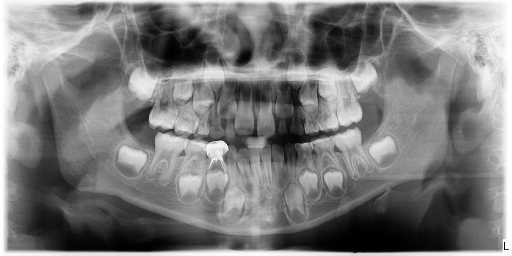

time: 70.1 ms (started: 2024-04-27 19:56:42 +00:00)


In [8]:
input_image = Image.open("/notebooks/Childrens dental segmentation dataset version 2/images/image_1.png")
input_image = np.array(input_image)
input_image = normalizeImages([input_image])
input_image = np.reshape(input_image, (256,512))
input_image = (input_image * 255).astype('uint8')
input_image = Image.fromarray(input_image)
input_image.show()

In [14]:
output_images = [gr.Image(label=f"Output {i+1}") for i in range(2)]


gr.Interface(
    fn=predict,
    inputs=gr.Image(),
    outputs=output_images,
).launch(share=True)

# demo = gr.Interface(predict, gr.Image(), "image")
# demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7864

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


time: 31 s (started: 2024-04-27 20:04:37 +00:00)


In [10]:
!pip uninstall gradio

ERROR: unknown command "unistall" - maybe you meant "uninstall"
time: 405 ms (started: 2024-04-27 19:57:14 +00:00)
